<a href="https://colab.research.google.com/github/aenoboa1/Draft_ML_EmotionAPP/blob/main/testing_daisee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install visualkeras

     |████████████████████████████████| 795 kB 9.1 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
from google.colab import drive
import visualkeras
drive._mount('/content/drive')


#matplotlib styles
plt.style.use(['ggplot'])
sns.set(rc={'figure.figsize':(11.7,8.27)})

Mounted at /content/drive


In [ ]:
!mkdir /content/DAiSEE ; unzip  -qq /content/drive/MyDrive/DATA/datasets/DAiSEE.zip -d /content/DAiSEE


In [ ]:
# SSH Tunnel para abrir en VS Code
!pip install colab_ssh --upgrade

from colab_ssh import launch_ssh
launch_ssh('21v23nE9rkUZAwWwJZ1zAxGLuwK_7v2uhNRStUAsGmaEtCm5D', 'ml')

we highly recommend that update your code by following this documentation https://github.com/WassimBenzarti/colab-ssh#getting-started
Successfully running 6.tcp.ngrok.io:10394
[Optional] You can also connect with VSCode SSH Remote extension using this configuration:

  Host google_colab_ssh
    HostName 6.tcp.ngrok.io
    User root
    Port 10394
    


In [ ]:
class_names = ['Boredom',
               'Engagement',
              'Confusion',
               'Frustration'
               ]


In [ ]:
df_train = pd.read_csv('/content/DAiSEE/DAiSEE/Labels/TrainLabels.csv')


In [ ]:
df_train

,ClipID,Boredom,Engagement,Confusion,Frustration
0,1100011002.avi,0,2,0,0
1,1100011003.avi,0,2,0,0
2,1100011004.avi,0,3,0,0
3,1100011005.avi,0,3,0,0
4,1100011006.avi,0,3,0,0
...,...,...,...,...,...
5353,4599990246.avi,0,3,0,0
5354,4599990247.avi,0,3,0,0
5355,4599990248.avi,1,2,1,1
5356,4599990249.avi,0,3,0,0


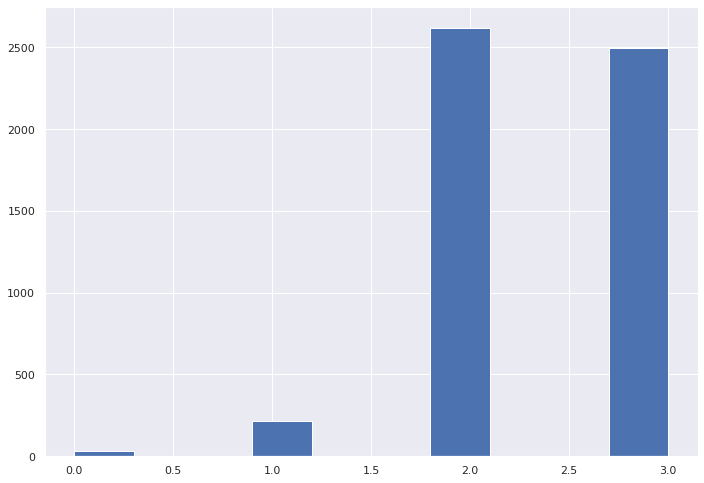

In [ ]:
df_train['Engagement'].hist()


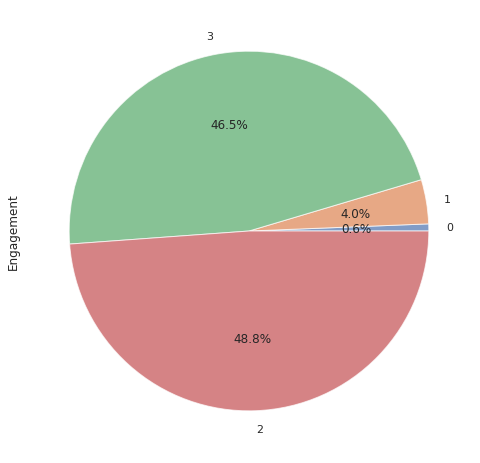

In [ ]:
df_train['Engagement'].value_counts().sort_values().plot.pie(wedgeprops={'alpha':0.7}, autopct='%1.1f%%')


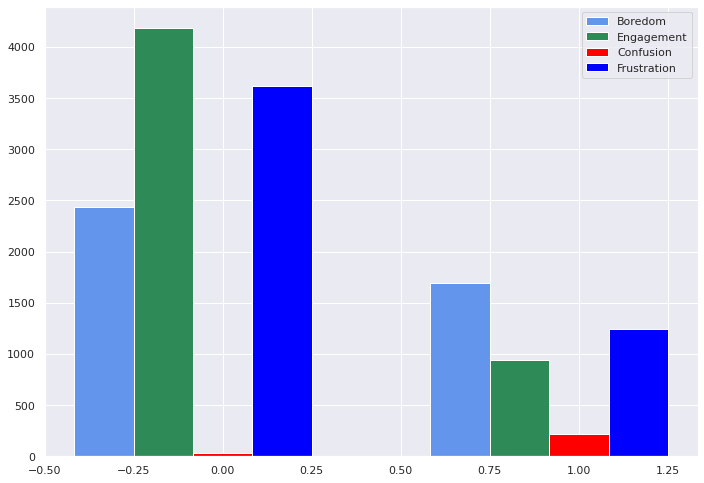

In [ ]:


fig, ax = plt.subplots()

d_heights, d_bins = np.histogram(df_train['Boredom'],bins=[-0.5,0.5,1.5])
m_heights, m_bins = np.histogram(df_train['Frustration '], bins=d_bins)
s_heights, s_bins = np.histogram(df_train['Engagement'], bins=m_bins)
ss_heights, ss_bins = np.histogram(df_train['Confusion'], bins=s_bins)


width = (d_bins[1] - d_bins[0])/6.0

ax.bar(d_bins[:-1]+width, d_heights, width=width, facecolor='cornflowerblue')
ax.bar(m_bins[:-1]+width*2, m_heights, width=width, facecolor='seagreen')
ax.bar(s_bins[:-1]+width*3, s_heights, width=width, facecolor='red')
ax.bar(ss_bins[:-1]+width*4, ss_heights, width=width, facecolor='blue')
ax.legend(class_names)


#### Aplicando la tecnica SMOTE al dataset

In [ ]:
df_train["Engagement"].value_counts()

2    2617
3    2494
1     213
0      34
Name: Engagement, dtype: int64

In [ ]:
count_class_2, count_class_3,count_class_1,count_class_0 = df_train["Engagement"].value_counts()

In [ ]:
count_class_2

2617

In [ ]:
count_class1

213

To install imbalanced-learn library use pip install imbalanced-learn command



In [ ]:
!pip install imbalanced-learn

### Transformando dataset a TFRecords para el training

In [ ]:
!git clone https://github.com/aenoboa1/Engagement-recognition-using-DAISEE-dataset

Cloning into 'Engagement-recognition-using-DAISEE-dataset'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 79 (delta 33), reused 47 (delta 13), pack-reused 0
Unpacking objects: 100% (79/79), done.


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np
import cv2
import os
from tqdm import tqdm
import tensorflow_datasets as tfds
import pandas as pd
import random


AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32
np.random.seed(0)

In [ ]:
class DataPreprocessing:
    def __init__(self,
                 IMG_HEIGHT=224,
                 IMG_WIDTH=224,
                 dataset_dir='/content/DAiSEE/DAiSEE/DataSet/Data/',
                 test_dir='Test/',
                 train_dir='Train/',
                 val_dir='Validation/',
                 labels_dir='/content/DAiSEE/DAiSEE/Labels/',
                 test_label='TestLabels.csv',
                 train_label='TrainLabels.csv',
                 val_label='ValidationLabels.csv',
                 data_augmentation_flag=False,
                 max_frames=3
                 ):
        self.IMG_HEIGHT = IMG_HEIGHT
        self.IMG_WIDTH = IMG_WIDTH
        self.dataset_dir = dataset_dir
        self.train_dir = self.dataset_dir+train_dir
        self.test_dir = self.dataset_dir+test_dir
        self.val_dir = self.dataset_dir+val_dir
        self.labels_dir = labels_dir
        self.train_label_dir = self.labels_dir + train_label
        self.test_label_dir = self.labels_dir + test_label
        self.val_label_dir = self.labels_dir + val_label
        self.data_augmentation_flag = data_augmentation_flag
        self.max_frames = max_frames
        self.face_cascade = cv2.CascadeClassifier('/content/Engagement-recognition-using-DAISEE-dataset/dataset/haarcascade_frontalface_default.xml')

    def get_images_from_set_dir(self, setdir):
        '''
        Method to find all images in the tree folder
        '''
        set_dir_images = []
        humans = os.listdir(setdir)
        for human in humans:
            human_dir = setdir + human + "/"
            videos = os.listdir(human_dir)
            for video in videos:
                video_dir = human_dir + video + "/"
                pictures = os.listdir(video_dir)
                pictures = random.sample(pictures, self.max_frames)
                for picture in pictures:
                    picture_dir = video_dir + picture
                    if picture.endswith(".jpg"):
                        set_dir_images.append(picture_dir)
        return set_dir_images

    def get_labels_dataframe(self):
        '''
        Method to read pandas dataframe
        '''
        train_df = pd.read_csv(self.train_label_dir, sep=",")
        test_df = pd.read_csv(self.test_label_dir, sep=",")
        val_df = pd.read_csv(self.val_label_dir, sep=",")
        return train_df, test_df, val_df

    def resize(self, image):
        return cv2.resize(image, (self.IMG_HEIGHT, self.IMG_WIDTH), interpolation=cv2.INTER_AREA)

    def face_cropping(self, image):
        # Crop and resize
        faces = self.face_cascade.detectMultiScale(image, 1.3, 5)
        try:
            if faces != 0:
                x, y, w, h = faces[0]
                image = image[y:y+h, x:x+w]
        except:
            pass
        return self.resize(image)

    def random_crop(self, image, crop_height, crop_width):
        max_x = image.shape[1] - crop_width
        max_y = image.shape[0] - crop_height

        x = np.random.randint(0, max_x)
        y = np.random.randint(0, max_y)

        crop = image[y: y + crop_height, x: x + crop_width]

        return self.face_cropping(crop)


    def augment_image(self, image):
        '''
        Applies some augmentation techniques
        '''
        # Mirror flip
        flipped = tf.image.flip_left_right(image).numpy()
        # Transpose flip
        transposed = tf.image.transpose(image).numpy()
        # Saturation
        satured = tf.image.adjust_saturation(image, 3).numpy()
        # Brightness
        brightness = tf.image.adjust_brightness(image, 0.4).numpy()
        # Contrast
        contrast = tf.image.random_contrast(image, lower=0.0, upper=1.0).numpy()
        # Resize at the end
        images = [self.resize(image) for image in [flipped, transposed, satured, brightness, contrast]]
        return images


    def get_label_picture(self, image_path, label_df):
        error_ = False
        video = image_path.split("/")[-2]
        label_series = label_df.loc[((label_df['ClipID'] == video+'.avi') | (label_df['ClipID'] == video+'.mp4'))]
        try:
            index = label_series.index.values[0]
            label = np.array([label_series['Boredom'].get(index),
                              label_series['Engagement'].get(index),
                              label_series['Confusion'].get(index),
                              label_series['Frustration '].get(index)])
            label_one_hot = (label >= 1).astype(np.uint8)
        except:
            print('Error in label picture')
            print(image_path)
            label_one_hot = ''
            error_ = True
        return label_one_hot, error_

    def _int64_feature(self, value):
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

    def _bytes_feature(self, value):
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    def writeTfRecord(self, output_dir, data_augmentation=False):
        '''
        Method to write tfrecord
        '''
        # open the TFRecords file
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Read dataframes
        train_df, test_df, val_df = self.get_labels_dataframe()

        # Objects to iterate
        objs = [('train', self.train_dir, train_df),
                ('test', self.test_dir, test_df),
                ('val', self.val_dir, val_df)]

        for name, dataset, label_df in tqdm(objs):
            # Open Writer
            writer = tf.io.TFRecordWriter(output_dir+name+'.tfrecords')
            # Get all the images of a set
            images_path = self.get_images_from_set_dir(dataset)
            for image_path in tqdm(images_path, total=len(images_path)):
                # Read the image from path
                img = cv2.imread(image_path)[..., ::-1]
                img = self.face_cropping(img)
                # Read the label
                label, error_ = self.get_label_picture(image_path, label_df)
                if error_:
                    continue
                # Create a feature
                if data_augmentation:
                    images = self.augment_image(img)
                else:
                    images = img
                for image in images:
                    feature = {'label': self._bytes_feature(tf.compat.as_bytes(label.tostring())),
                               'image': self._bytes_feature(tf.compat.as_bytes(image.tostring()))}
                    # Create an example protocol buffer
                    example = tf.train.Example(features=tf.train.Features(feature=feature))

                    # Serialize to string and write on the file
                    writer.write(example.SerializeToString())
            writer.close()

    def decode(self, serialized_example):
        """
        Parses an image and label from the given `serialized_example`.
        It is used as a map function for `dataset.map`
        """
        IMAGE_SHAPE = (self.IMG_HEIGHT, self.IMG_WIDTH, 3)

        # 1. define a parser
        features = tf.io.parse_single_example(
            serialized_example,
            # Defaults are not specified since both keys are required.
            features={
                'image': tf.io.FixedLenFeature([], tf.string),
                'label': tf.io.FixedLenFeature([], tf.string),
            })

        # 2. Convert the data
        image = tf.io.decode_raw(features['image'], tf.uint8)
        label = tf.io.decode_raw(features['label'], tf.uint8)

        # Cast
        label = tf.cast(label, tf.float32)

        # 3. reshape
        image = tf.convert_to_tensor(tf.reshape(image, IMAGE_SHAPE))

        return image, label

In [ ]:
preprocessing_class = DataPreprocessing()
# Write tf recordfloat32
preprocessing_class.writeTfRecord('tfrecords/', data_augmentation=True)

# Read TfRecord
tfrecord_path = 'tfrecords/train.tfrecords'
dataset = tf.data.TFRecordDataset(tfrecord_path)

# Parse the record into tensors with map.
# map takes a Python function and applies it to every sample.
dataset = dataset.map(preprocessing_class.decode)

# Divide in batch
dataset = dataset.batch(batch_size)

# Create an iterator
iterator = iter(dataset)

# Element of iterator
a = iterator.get_next()

In [ ]:
! zip -r tfrecords.zip /content/tfrecords ; cp tfrecords.zip /content/drive/MyDrive/DATA

  adding: content/tfrecords/ (stored 0%)
  adding: content/tfrecords/test.tfrecords (deflated 73%)
  adding: content/tfrecords/train.tfrecords (deflated 63%)
  adding: content/tfrecords/val.tfrecords (deflated 78%)


## Engagement Recognition

In [ ]:
!python /content/Engagement-recognition-using-DAISEE-dataset/daisee_data_preprocessing.py

In [ ]:
!python /content/Engagement-recognition-using-DAISEE-dataset/train.py

### Train Code - XCeption Test

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as kl
import tensorflow.keras.losses
from tensorflow.keras.applications.resnet50 import ResNet50


In [ ]:
!wget https://raw.githubusercontent.com/aenoboa1/Engagement-recognition-using-DAISEE-dataset/master/daisee_data_preprocessing.py

--2022-01-02 03:07:52--  https://raw.githubusercontent.com/aenoboa1/Engagement-recognition-using-DAISEE-dataset/master/daisee_data_preprocessing.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8681 (8.5K) [text/plain]
Saving to: ‘daisee_data_preprocessing.py’

daisee_data_preproc 100%[===================>]   8.48K  --.-KB/s    in 0s      

2022-01-02 03:07:52 (84.2 MB/s) - ‘daisee_data_preprocessing.py’ saved [8681/8681]



In [ ]:
from daisee_data_preprocessing import DataPreprocessing
import datetime
import os
from tqdm import tqdm

In [ ]:
BATCH_SIZE = 32
LR = 0.005
EPOCHS = 10

In [ ]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_dir = 'checkpoints/'
log_dir = 'logs/'


In [ ]:
preprocessing_class = DataPreprocessing()


In [ ]:
# Open train set
tfrecord_path = '/content/tfrecords/test.tfrecords'
train_set = tf.data.TFRecordDataset(tfrecord_path)
# Parse the record into tensors with map.
train_set = train_set.map(preprocessing_class.decode)
train_set = train_set.shuffle(1)
train_set = train_set.batch(BATCH_SIZE)

In [ ]:
# Open test set
tfrecord_path = '/content/tfrecords/train.tfrecords'
test_set = tf.data.TFRecordDataset(tfrecord_path)
# Parse the record into tensors with map.
test_set = test_set.map(preprocessing_class.decode)
test_set = test_set.shuffle(1)
test_set = test_set.batch(BATCH_SIZE)

In [ ]:
# Open val set
tfrecord_path = '/content/tfrecords/val.tfrecords'
val_set = tf.data.TFRecordDataset(tfrecord_path)
# Parse the record into tensors with map.
val_set = val_set.map(preprocessing_class.decode)
val_set = val_set.shuffle(1)
val_set = val_set.batch(BATCH_SIZE)

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=1)
X_smote = sm.fit_resample(train_set)



TypeError: ignored

In [ ]:
def create_log_dir(log_dir, checkpoint_dir):
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
    if not os.path.exists(checkpoint_dir):
        os.mkdir(checkpoint_dir)

In [ ]:
BATCH_SIZE = 32
LR = 0.005
EPOCHS = 20

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16


In [ ]:
def build_model():
    model = tf.keras.Sequential()
    model.add(kl.InputLayer(input_shape=(224, 224, 3)))
    if use_pretrained:
        if pretrained_name == 'vgg':
            vgg = VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
            vgg.trainable = False
            model.add(vgg)
        if pretrained_name == 'mobilenet':
            mobnet = MobileNetV2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
            mobnet.trainable = False
            model.add(mobnet)
    else:
        # First conv block
        model.add(kl.Conv2D(filters=128, kernel_size=3, padding='same', strides=2))
        model.add(tf.keras.layers.ReLU())
        model.add(kl.MaxPooling2D(pool_size=(2, 2)))
        # Second conv block
        model.add(kl.Conv2D(filters=256, kernel_size=3, padding='same', strides=2))
        model.add(tf.keras.layers.ReLU())
        model.add(kl.MaxPooling2D(pool_size=(2, 2)))
        # Third conv block
        model.add(kl.Conv2D(filters=512, kernel_size=3, padding='same', strides=2))
        model.add(tf.keras.layers.ReLU())
        model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    # Flatten
    model.add(kl.Flatten())
    # First FC
    model.add(kl.Dense(1024))
    # Second Fc
    model.add(kl.Dense(256))
    # Output FC with sigmoid at the end
    model.add(kl.Dense(4, activation='sigmoid', name='prediction'))

    optimizer = keras.optimizers.RMSprop(learning_rate=LR)

    loss = keras.losses.CategoricalCrossentropy(from_logits=False)

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


    return model

In [ ]:
# Loading the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
import visualkeras
import pandas as pd
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input


In [ ]:
def build_model(alpha=0.01):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    base_model.trainable = False

    # actual model 



    inputs = keras.Input(shape=(224, 224, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(4,activation='softmax')(vectors)
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.RMSprop(learning_rate=alpha)

    loss = keras.losses.CategoricalCrossentropy(from_logits=False)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])



    return model

In [ ]:
use_pretrained = True
pretrained_name = 'vgg'


In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_15 (Dense)            (None, 131)               268419    
                                                                 
Total params: 21,129,899
Trainable params: 268,419
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
history = model.fit(
    train_set, 
    epochs=EPOCHS, 
    validation_data=val_set)

Epoch 1/20
834/834 [==============================] - 115s 139ms/step - loss: 226.1175 - accuracy: 0.4749 - val_loss: 201.5798 - val_accuracy: 0.3083
Epoch 2/20
834/834 [==============================] - 114s 136ms/step - loss: 214.4299 - accuracy: 0.4621 - val_loss: 252.2291 - val_accuracy: 0.3083
Epoch 3/20
834/834 [==============================] - 113s 136ms/step - loss: 223.0627 - accuracy: 0.4685 - val_loss: 221.0346 - val_accuracy: 0.0509
Epoch 4/20
834/834 [==============================] - 113s 136ms/step - loss: 224.6670 - accuracy: 0.4583 - val_loss: 291.4684 - val_accuracy: 0.3083
Epoch 5/20
834/834 [==============================] - 113s 136ms/step - loss: 226.0584 - accuracy: 0.4603 - val_loss: 194.8815 - val_accuracy: 0.3083
Epoch 6/20
834/834 [==============================] - 114s 136ms/step - loss: 224.4773 - accuracy: 0.4646 - val_loss: 84.0669 - val_accuracy: 0.6043
Epoch 7/20
834/834 [==============================] - 114s 136ms/step - loss: 227.3481 - accuracy: 0.

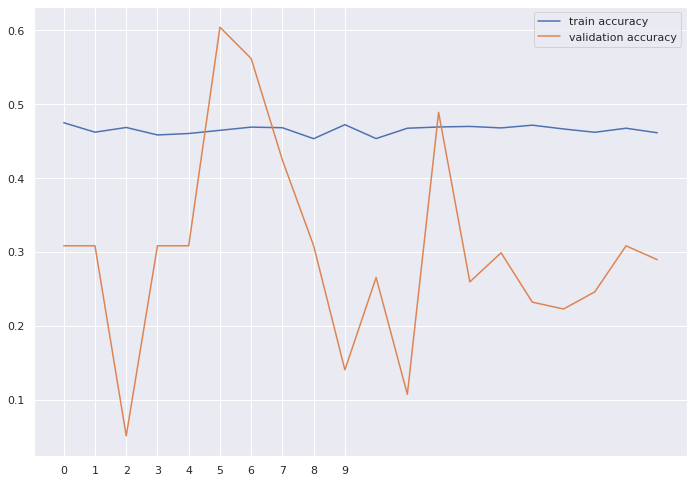

In [ ]:
#plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['accuracy'], label='train accuracy')

plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xticks(np.arange(10))
plt.legend()


In [ ]:
model = network()

In [ ]:
!pip install visualkeras ; ! pip install ThreadedFileLoader # module for CNN visualization


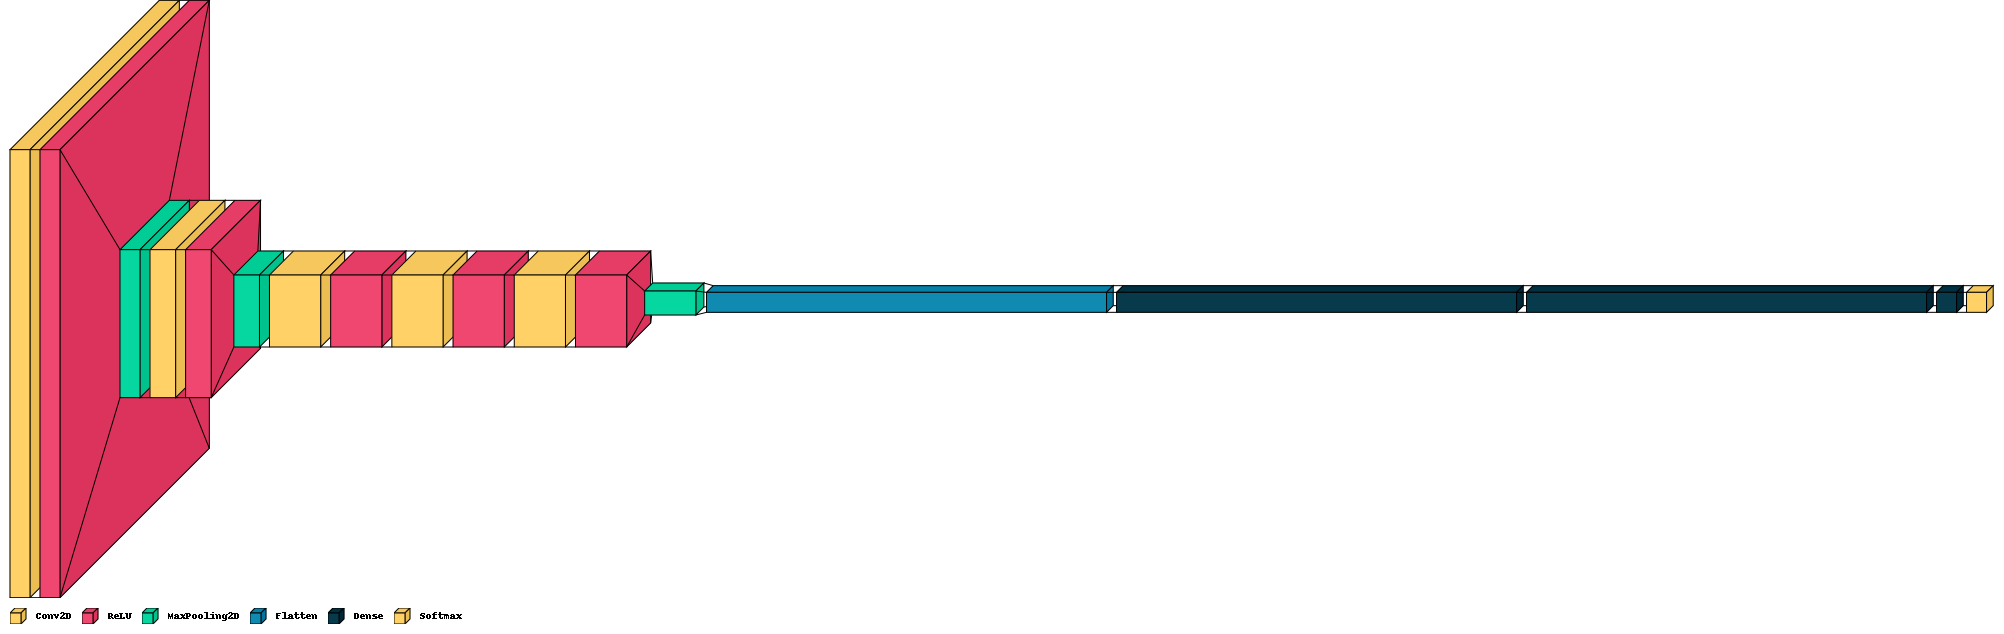

In [ ]:
visualkeras.layered_view(model).show()
visualkeras.layered_view(model,legend=True)

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x)
        loss_value = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    # Track progress
    train_loss_avg.update_state(loss_value)
    train_accuracy.update_state(y, logits)
    return loss_value

In [ ]:
@tf.function
def test_step(x, y, set_name):
    logits = model(x)
    if set_name == 'val':
        val_accuracy.update_state(y, logits)
    else:
        test_accuracy.update_state(y, logits)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
create_log_dir(log_dir, checkpoint_dir)
train_summary_writer = tf.summary.create_file_writer(log_dir)

In [ ]:
train_loss_avg = tf.keras.metrics.Mean()
train_accuracy = tf.keras.metrics.MeanAbsoluteError()
val_accuracy = tf.keras.metrics.MeanAbsoluteError()
test_accuracy = tf.keras.metrics.MeanAbsoluteError()

In [ ]:
for epoch in range(EPOCHS):
    # Training loop
    for x_batch_train, y_batch_train in tqdm(train_set, total=1517):
        # Do step
        loss_value = train_step(x_batch_train, y_batch_train)
        
    # Test on validation set
    for x_batch_val, y_batch_val in val_set:
        test_step(x_batch_val, y_batch_val, 'val')
    
    # Reset training metrics at the end of each epoch
    train_acc = train_accuracy.result()
    train_accuracy.reset_states()
    val_acc = val_accuracy.result()
    val_accuracy.reset_states()
    
    with train_summary_writer.as_default():
        tf.summary.scalar('Train loss', train_loss_avg.result(), step=epoch)
        tf.summary.scalar('Train MAE', train_acc, step=epoch)
        tf.summary.scalar('Val MAE', val_acc, step=epoch)
        
    if epoch % 10 == 0:
        tf.keras.models.save_model(model, '{}/Epoch_{}_model.hp5'.format(checkpoint_dir, str(epoch)), save_format="h5")

 55%|█████▍    | 833/1517 [00:39<00:32, 20.84it/s]


 55%|█████▍    | 833/1517 [00:39<00:32, 20.88it/s]


In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir /content/logs

In [ ]:
# Test on validation set
for x_batch_test, y_batch_test in test_set:
    test_step(x_batch_test, y_batch_test, 'test')
test_set_acc = test_accuracy.result()

In [ ]:
display(test_set_acc)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

### Saving Models

In [ ]:
!zip -r scratch_models.zip /content/checkpoints/scratch_aug

  adding: content/checkpoints/scratch_aug/ (stored 0%)
  adding: content/checkpoints/scratch_aug/Epoch_250_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_0_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_350_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_450_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_100_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_200_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_50_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_400_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_150_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_300_model.hp5 (deflated 7%)
  adding: content/checkpoints/scratch_aug/Epoch_500_model.hp5 (deflated 7%)


In [ ]:
import tensorflow as tf 
raw_dataset = tf.data.TFRecordDataset("/content/tfrecords/train.tfrecords")

for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)

In [ ]:
example


## Testing predictions

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
GCS_PATH = "/"
BATCH_SIZE = 64
IMAGE_SIZE = [1024, 1024]

In [ ]:
model.compile()

In [ ]:
from keras.models import load_model

model =load_model('/content/checkpoints/Epoch_0_model.hp5')


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 96)      14208     
                                                                 
 re_lu (ReLU)                (None, 112, 112, 96)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 256)       614656    
                                                                 
 re_lu_1 (ReLU)              (None, 37, 37, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 256)      0         
 2D)                                                    

In [ ]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('/content/DAiSEE/DAiSEE/DataSet/Data/Train/310082/3100821015/310082101534.jpg')

In [ ]:
image

array([[[[0.7294118 , 0.6862745 , 0.7176471 ],
         [0.7294118 , 0.6862745 , 0.7176471 ],
         [0.7294118 , 0.6862745 , 0.7176471 ],
         ...,
         [0.7890167 , 0.72235006, 0.7537226 ],
         [0.7882354 , 0.72156876, 0.7529413 ],
         [0.7882353 , 0.72156864, 0.7529412 ]],

        [[0.7294118 , 0.6862745 , 0.7176471 ],
         [0.7294118 , 0.6862745 , 0.7176471 ],
         [0.7294118 , 0.6862745 , 0.7176471 ],
         ...,
         [0.7890167 , 0.72235006, 0.7537226 ],
         [0.7882354 , 0.72156876, 0.7529413 ],
         [0.7882353 , 0.72156864, 0.7529412 ]],

        [[0.7294118 , 0.6862745 , 0.7176471 ],
         [0.7294118 , 0.6862745 , 0.7176471 ],
         [0.7294118 , 0.6862745 , 0.7176471 ],
         ...,
         [0.7890167 , 0.72235006, 0.7537226 ],
         [0.7882354 , 0.72156876, 0.7529413 ],
         [0.7882353 , 0.72156864, 0.7529412 ]],

        ...,

        [[0.19215687, 0.26666668, 0.39607844],
         [0.19215798, 0.2666678 , 0.39607957]

In [ ]:
model.predict(image)

array([[1.3776677e-06, 9.9999857e-01, 3.2351309e-18, 0.0000000e+00]],
      dtype=float32)

### Method 2 : RESNET+ TCN 


#### Code Description:

The input is training and validation raw frames extracted from videos and placed in separate folders (using `extractFramesOpenCV.py`). The address of the folders (containing video frames) and corresponding labels should be provided in two csv files, train.csv and validation.csv as follows
 
```python
path,label
/home/videos/train/826412/8264120240/,0
/home/videos/train/510034/5100342024/,1
/home/videos/train/500067/5000671065/,2
...
```

`datasets.py` and `transforms.py` read the video frames based on their address in the csv files, preprocess and normalize them, and convert them to [PyTorch dataloaders](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

The ResNet-TCN Hybrid Architecture is in `ResTCN.py`. In the class `ResTCN` and the function `forward`, [resnet18](https://pytorch.org/vision/0.8/models.html#torchvision.models.resnet18) extracts features from consecutive frames of video, and [TCN](https://github.com/locuslab/TCN) analyzes changes in the extracted features, and fully-connected layers output the final prediction.

Training and validation phases are performed in `train.py`. Training the ResNet and TCN is performed jointly using [Adam](https://pytorch.org/docs/stable/optim.html) optimization algorithm.

The input to the ResTCN model should have this format: inputs = torch.randn([batch_size, sequence_length, num_channels, frame_width, frame_height]), for instance

```
import torch
from ResTCN import ResTCN
model = ResTCN().cuda()
inputs = torch.randn([16, 30, 3, 256, 256]).cuda()
outputs = model(inputs)
```

The code has been tested on the [DAiSEE](https://iith.ac.in/~daisee-dataset/), Dataset for Affective States in E-Environments, for engagement level classification in online classrooms.



In [6]:
!git clone https://github.com/aenoboa1/Draft_ML_EmotionAPP

Cloning into 'Draft_ML_EmotionAPP'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 136 (delta 43), reused 6 (delta 1), pack-reused 44
Receiving objects: 100% (136/136), 18.30 MiB | 7.10 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [ ]:
!git clone https://github.com/aenoboa1/ResNet-TCN

Cloning into 'ResNet-TCN'...
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 201 (delta 4), reused 0 (delta 0), pack-reused 188
Receiving objects: 100% (201/201), 2.65 MiB | 6.70 MiB/s, done.
Resolving deltas: 100% (92/92), done.


## Loading dataimages:

In [ ]:
!mkdir /content/DAiSEE2 ; unzip  -qq /content/drive/MyDrive/DATA/DAiSEE.zip -d /content/DAiSEE2

/content/DAiSEE2/DAiSEE/DataSet/Train/210055/2100552061/2100552061.avi  bad CRC 2993cec4  (should be 713f368f)


In [ ]:
!python /content/ResNet-TCN/extractFramesOpenCV.py

In [7]:
import torch
import torchvision
import cv2
import os


class VideoFolderPathToTensor(object):

    def __init__(self, max_len=None):
        self.max_len = max_len

    def __call__(self, path):

        file_names = sorted([os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
        frames_path = [os.path.join(path, f) for f in file_names]

        frame = cv2.imread(frames_path[0])
        height, width, channels = frame.shape
        num_frames = len(frames_path)

        transform = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            torchvision.transforms.Resize([224, 224])
        ])

        # EXTRACT_FREQUENCY = 18
        EXTRACT_FREQUENCY = 1

        # num_time_steps = int(num_frames / EXTRACT_FREQUENCY)

        num_time_steps = 16
        # num_time_steps = 4

        # (3 x T x H x W), https://pytorch.org/docs/stable/torchvision/models.html
        frames = torch.FloatTensor(channels, num_time_steps, 224, 224)

        for index in range(0, num_time_steps):
            frame = cv2.imread(frames_path[index * EXTRACT_FREQUENCY])
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = torch.from_numpy(frame)
            frame = frame.permute(2, 0, 1)  # (H x W x C) to (C x H x W)
            frame = frame / 255
            if frame.shape[2] != 224:
                frame = frame[:, :, 80:560]
            frame = transform(frame)
            frames[:, index, :, :] = frame.float()

        return frames.permute(1, 0, 2, 3)


In [8]:
from torch.utils.data import Dataset
import pandas as pd
import os


class VideoDataset(Dataset):

    def __init__(self, csv, root, transform=None):

        self.dataframe = pd.read_csv(csv)
        self.transform = transform
        self.root = root

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):

        label = self.dataframe.iloc[index].label
        video = os.path.join(self.root, self.dataframe.iloc[index].path)
        video = self.transform(video)

        return video, label


In [11]:
import torchvision
from torch.utils.data import DataLoader


def generate_dataloader(batch_size, csv, root):
    dataset = VideoDataset(csv,
                          root,
                          transform=torchvision.transforms.Compose([VideoFolderPathToTensor()]))

    return DataLoader(dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=4)



In [9]:
def get_dataloader(batch_size, csv_train, root_train, csv_test, root_test):
    return {
        'train': generate_dataloader(batch_size, csv_train, root_train),
        'test': generate_dataloader(batch_size, csv_test, root_test)}

In [12]:
import os
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import torch
from torch import nn, optim
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

import numpy as np


torch.manual_seed(0)
num_epochs = 10
batch_size = 4
lr = .001
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
print("Device being used:", device, flush=True)


dataloader = get_dataloader(batch_size,
                            '/content/Draft_ML_EmotionAPP/pytorch_labels/labels_daisee_train.csv',
                            os.path.join(os.getcwd(), '/content/DAiSEE/DAiSEE/DataSet/Data/Train/'),
                            '/content/Draft_ML_EmotionAPP/pytorch_labels/labels_daisee_test.csv',
                            os.path.join(os.getcwd(), '/content/DAiSEE/DAiSEE/DataSet/Data/Test/'))

dataset_sizes = {x: len(dataloader[x].dataset) for x in ['train', 'test']}

print(dataset_sizes, flush=True)

Device being used: cuda
{'train': 5358, 'test': 1784}


In [13]:
import torch.nn as nn
from torch.nn.utils import weight_norm

In [14]:

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size - 1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [15]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


class ResTCN(nn.Module):
    def __init__(self):
        super(ResTCN, self).__init__()

        self.spatial_feat_dim = 32
        self.num_classes = 4
        self.nhid = 128
        self.levels = 8
        self.kernel_size = 7
        self.dropout = .1
        self.channel_sizes = [self.nhid] * self.levels

        self.tcn = TemporalConvNet(
            self.spatial_feat_dim,
            self.channel_sizes,
            kernel_size=self.kernel_size,
            dropout=self.dropout)
        self.linear = nn.Linear(self.channel_sizes[-1], self.num_classes)

        self.model_conv = torchvision.models.resnet18(pretrained=True)
        # for param in self.model_conv.parameters():
        #     param.requires_grad = False

        num_ftrs = self.model_conv.fc.in_features
        # self.model_conv.fc = nn.Linear(num_ftrs, 4)
        self.model_conv.fc = nn.Linear(num_ftrs, self.spatial_feat_dim)
        # self.model_conv.fc = Identity()

        # self.rnn = nn.LSTM(self.spatial_feat_dim, 64, 1, batch_first=True)
        # self.linear = nn.Linear(64, 4)

    def forward(self, data):
        # t = 0
        # x = data[:, t, :, :, :]
        # output = self.model_conv(x)

        z = torch.zeros([data.shape[0], data.shape[1], self.spatial_feat_dim]).cuda()
        for t in range(data.size(1)):
            x = self.model_conv(data[:, t, :, :, :])
            z[:, t, :] = x

        # y, _ = self.rnn(z)
        # output = self.linear(torch.sum(y, dim=1))

        z = z.transpose(1, 2)
        y = self.tcn(z)
        # output = self.linear(y[:, :, -1])
        output = self.linear(torch.sum(y, dim=2))

        return output

In [16]:
def Build_ResTCN():
      model = ResTCN().to(device)
      # optimizer = optim.Adam(model.parameters(), lr=lr)
      optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
      scheduler = StepLR(optimizer, step_size=50, gamma=.1)

      criterion = nn.CrossEntropyLoss().to(device)
      softmax = nn.Softmax()

      for epoch in range(num_epochs):

          for phase in ['train', 'test']:

              running_loss = .0
              y_trues = np.empty([0])
              y_preds = np.empty([0])

              if phase == 'train':
                  model.train()
              else:
                  model.eval()

              for inputs, labels in tqdm(dataloader[phase], disable=True):
                  inputs = inputs.to(device)
                  labels = labels.long().squeeze().to(device)

                  with torch.set_grad_enabled(phase == 'train'):
                      outputs = model(inputs).squeeze()
                      loss = criterion(outputs, labels)

                      if phase == 'train':
                          optimizer.zero_grad()
                          loss.backward()
                          optimizer.step()

                  running_loss += loss.item() * inputs.size(0)
                  preds = torch.max(softmax(outputs), 1)[1]
                  y_trues = np.append(y_trues, labels.data.cpu().numpy())
                  y_preds = np.append(y_preds, preds.cpu())

              # if phase == 'train':
              #     scheduler.step()

              epoch_loss = running_loss / dataset_sizes[phase]

              print("[{}] Epoch: {}/{} Loss: {} LR: {}".format(
                  phase, epoch + 1, num_epochs, epoch_loss, scheduler.get_last_lr()), flush=True)
              print('\naccuracy\t' + str(accuracy_score(y_trues, y_preds)))
      print('\nconfusion matrix\n' + str(confusion_matrix(y_trues, y_preds)))
      return model


In [17]:
model = Build_ResTCN()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[train] Epoch: 1/10 Loss: 0.8932161487808598 LR: [0.001]

accuracy	0.5078387458006719


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[test] Epoch: 1/10 Loss: 0.8814121304338823 LR: [0.001]

accuracy	0.5056053811659192


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[train] Epoch: 2/10 Loss: 0.8586369319921467 LR: [0.001]

accuracy	0.5393803658081374


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[test] Epoch: 2/10 Loss: 0.8657680260760902 LR: [0.001]

accuracy	0.4562780269058296


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[train] Epoch: 3/10 Loss: 0.8495992781645151 LR: [0.001]

accuracy	0.5636431504292646


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: ignored

## Test Predictions Pytorch RESTCN